### Introduction

I often am confused as to why my running performance (as perceived in mid-run and as detected by my phone post-run) varies so greatly over time. While academics and general life stress that are not as easily trackable are inherently going to weigh on me, I wanted to see if my running performance in a certain past window would inhibit or, on the contrary, boost performance. For example, would the fact that I have been training for a self-imposed half-marathon for the past week make my speed worse over time as I prioritized just getting through the workout? So, I exported my automatically generated Samsung Health data, narrowed the examination area to when I started to most consistently run (or rather, to gather data) (years 2021 and 2022), and conducted some basic regression analyses.

### Pre-processing

One of the issues with my data was that the automatic recorder tracked workouts with pauses or (seemingly random) slow-downs as separate workouts. Since I wanted to predict running performance day-by-day, I aggregated the runs that were listed as created on the same day. Additionally, I converted the units of different Samsung Health measurements into easily interpretable ones and listed them in the column names.

In [1]:
import pandas as pd
ex_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRVBc65_T88mP5J6lJ7iRkaWwxEXxAjG8F_N8j9FOUf-h1jzB5qaGUaiPO3lyXkFWtJZn7pCOEpe1G2/pub?gid=310481983&single=true&output=csv', sep='\,', engine='python', on_bad_lines='skip')


# rename columns that start with com.samsung.health.exercise 
ex_df.rename(columns=lambda x: x.replace('com.samsung.health.exercise.', ''), inplace=True)
ex_df.head()

# make columns start_time, end_time into datetime format dd-mm-yy hh:mm
ex_df['start_time'] = pd.to_datetime(ex_df['start_time'])
ex_df['end_time'] = pd.to_datetime(ex_df['end_time'])

# turn update time and create time into date format
ex_df['update_time'] = pd.to_datetime(ex_df['update_time']).dt.date
ex_df['create_time'] = pd.to_datetime(ex_df['create_time']).dt.date

# make ex_df only where count > 0 and exercise type 1002 and date start after September 1, 2020 and before January 1, 2023, given that the data format is dd-mm-yy hh:mm
ex_df = ex_df[ex_df['exercise_type'] == 1002]
ex_df = ex_df[ex_df['count'] > 0]
ex_df = ex_df[ex_df['start_time'] >= '01-01-21 00:00']
ex_df = ex_df[ex_df['start_time'] < '01-01-23 00:00']

# only use selected columns for a new df
ex_df = ex_df[['duration',  'start_time', 'update_time', 'create_time',  'max_speed', 'count', 'distance', 'calorie', 'time_offset', 'mean_speed', 'end_time',]]

# convert milliseconds to minutes
ex_df['duration'] = ex_df['duration'] / 60000

# convert meters per second into km per hour for max_speed and mean_speed
ex_df['max_speed'] = ex_df['max_speed'] * 3.6
ex_df['mean_speed'] = ex_df['mean_speed'] * 3.6

# convert meters to kilometers in distance
ex_df['distance'] = ex_df['distance'] / 1000

# rename columns to include units
ex_df.rename(columns={'duration': 'duration (min)', 'max_speed': 'max_speed (km/h)', 'mean_speed': 'mean_speed (km/h)', 'distance': 'distance (km)', 'calorie': 'calorie (kcal)', 'count' : 'step_count', 'update_time' : 'update_date', 'create_time' : 'create_date'}, inplace=True)


# for exercise that has the same create_date, add distance (km) and step_count and calorie (kcal) together; average mean_speed, keep max_speed; keep the later end_time and the earlier start_time and time offset, recalculate duration from start to end time
ex_df = ex_df.sort_values(by=['create_date', 'update_date', 'time_offset', 'start_time', 'end_time'])

# SQL but in Python
ex_df = ex_df.groupby(['create_date', 'update_date', 'time_offset']).agg({'distance (km)' : 'sum', 'step_count' : 'sum', 'calorie (kcal)' : 'sum', 'mean_speed (km/h)' : 'mean', 'max_speed (km/h)' : 'max', 'duration (min)' : 'sum', 'start_time' : 'min', 'end_time' : 'max'}).reset_index()


print('Rows by columns:', ex_df.shape)

# count NA values in each column
print('\n Null values:')
print(ex_df.isnull().sum())
ex_df.head()



/var/folders/4t/ddfqyc995sl4jwpdczms8knr0000gn/T/ipykernel_99838/4198924463.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ex_df['start_time'] = pd.to_datetime(ex_df['start_time'])
/var/folders/4t/ddfqyc995sl4jwpdczms8knr0000gn/T/ipykernel_99838/4198924463.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ex_df['end_time'] = pd.to_datetime(ex_df['end_time'])
/var/folders/4t/ddfqyc995sl4jwpdczms8knr0000gn/T/ipykernel_99838/4198924463.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ex_df['update_time'] = pd.to_datetime(ex_df['update_time']).dt.date
/var/folders/

Rows by columns: (625, 11)

 Null values:
create_date          0
update_date          0
time_offset          0
distance (km)        0
step_count           0
calorie (kcal)       0
mean_speed (km/h)    0
max_speed (km/h)     0
duration (min)       0
start_time           0
end_time             0
dtype: int64


,create_date,update_date,time_offset,distance (km),step_count,calorie (kcal),mean_speed (km/h),max_speed (km/h),duration (min),start_time,end_time
0,2021-01-02,2021-01-02,UTC-0400,8.60053,7800.0,488.28000,11.392663,12.900000,45.295100,2021-01-02 09:52:00,2021-01-02 10:37:00
1,2021-01-03,2021-01-03,UTC-0400,13.98238,12803.0,783.65998,11.268067,12.700000,74.644483,2021-01-03 09:40:00,2021-01-03 10:55:00
2,2021-01-05,2021-01-05,UTC-0400,13.72435,12600.0,758.98000,11.334182,14.700001,72.652883,2021-01-05 09:42:00,2021-01-05 10:54:00
3,2021-01-06,2021-01-06,UTC-0400,15.15190,13499.0,969.59000,11.719901,13.900000,77.570117,2021-01-06 09:46:00,2021-01-06 11:03:00
4,2021-01-07,2021-01-07,UTC-0400,13.21606,11800.0,894.77997,11.825511,14.599999,67.055333,2021-01-07 09:55:00,2021-01-07 11:02:00


As a sanity check, I plotted the step count on each exercise date and counted the null values in each column of the dataframe. Since the plot looked like accurate time series data, and there were no null values, I think, the pre-processing was a success. 

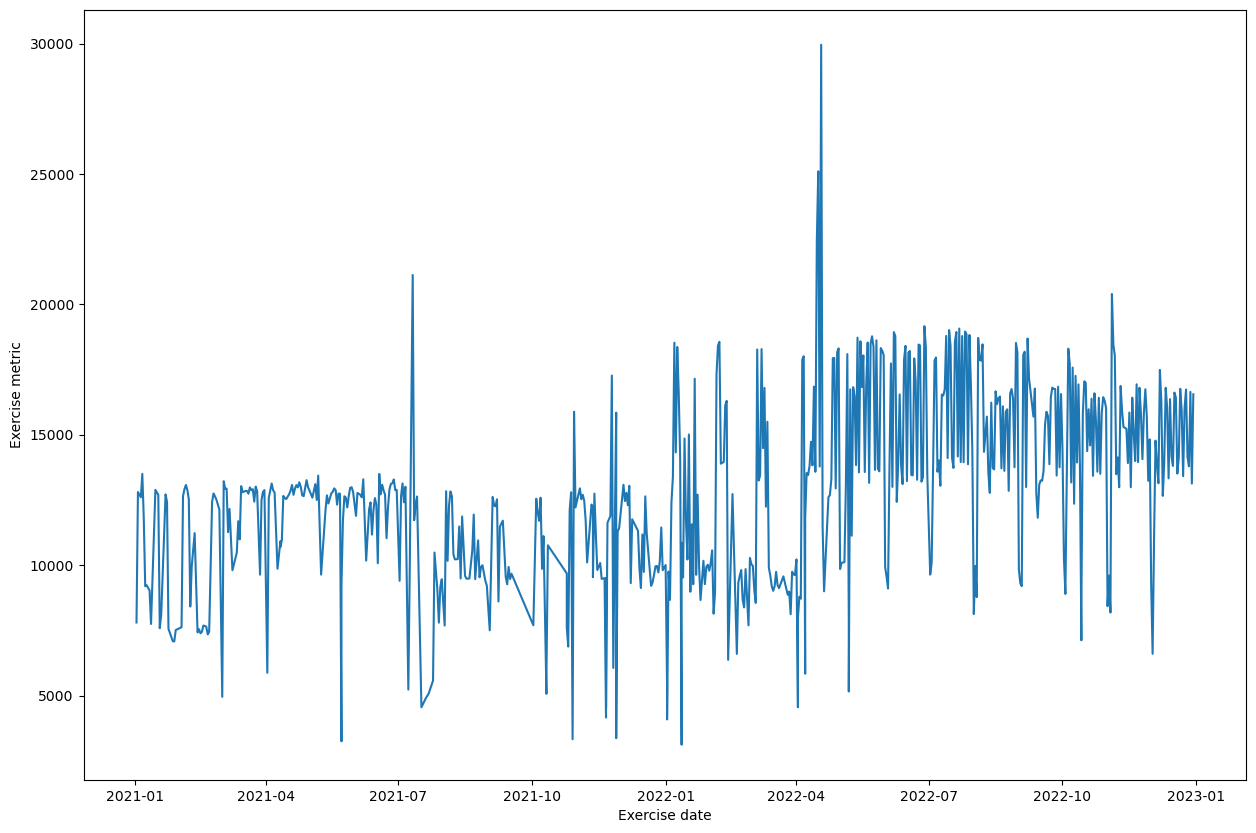

In [2]:
import matplotlib.pyplot as plt

# plot time series data
plt.figure(figsize=(15,10))
plt.plot(ex_df['create_date'], ex_df['step_count'], label='Step count')
#plt.plot(ex_df['create_date'], ex_df['mean_speed (km/h)'], label='Mean speed (km/h)')
plt.xlabel('Exercise date')
plt.ylabel('Exercise metric')
#plt.legend()
plt.show()

### Exploratory Visualizations

In [3]:
import seaborn as sns

# plot heatmap of correlation between variables on one of the subplots
sns.heatmap(ex_df.corr(), annot=True)
plt.title('Heatmap of correlation between variables')
plt.show()

# plot histogram of mean speed (km/h)
plt.hist(ex_df['mean_speed (km/h)'])
plt.title('Histogram of mean speed')
plt.xlabel('Mean speed (km/h)')
plt.show()

# plot mean speed over time
plt.plot(ex_df['create_date'], ex_df['mean_speed (km/h)'])
plt.title('Mean speed over time')
plt.xlabel('Exercise date')
plt.ylabel('Mean speed (km/h)')
plt.show()

# # plot pairplot
# sns.pairplot(ex_df)
# plt.title('Pairplot of variables')
# plt.show()

# describe mean speed
print('Mean speed (km/h):')
print(ex_df['mean_speed (km/h)'].describe())




ValueError: could not convert string to float: 'UTC-0400'

As can be observed from the heatmap, distance, step count, calories, and duration are heavily correlated with each other. This suggests that some of them can be removed. However, I will not be doing that given my model selection (see below). Meanwhile, mean speed and max speed are not only uncorrelated with each other, but they are also not strongly correlated with any of the other components individually. In other words it would not be possible to just use one variable to predict mean speed (my desired performance metric). 

The histogram and the describe attribute of the dataframe corresponding to mean speed show that it the 625 observations are primarily distributed between 10.5 and 11.3 kilometers per hour. The distribution of the mean speed is left-skewed by some of the lower performance, which, based on the time-series plot, you can see happened around October 2021 - December 2021. I blame it on Seoul's steepy hill surface and the requirements to wear masks even when outside, exercising. I am also noting the standard deviation of the speed, 0.835, to be used as a comparison metric when running later models.

### Plans for this project

In short, I want to figure out what window of past performance is influential on future performance; and, what features of past performance are most important (e.g., average distance I've ran or average speed over the past X days). Specifically, I will use the data from the past (distance, duration, calories burned, and max speed) to predict future performance (mean speed after a period of time). To reiterate, I will vary the possible window sizes from 1 to 7 to 14. In other words, for window size of 7, I would use data from January 1 through January 7 to predict the mean speed on January 8. Then, I would use data from January 2 through 8 to predict speed on January 9. And, so on.

Since this is time series data, and I want to mix the aggregate effect of variables from the predictors' window size, I will use several pandas' aggregation functions to group information from previous periods. Most values were averaged out through weighted average, by assigning higher weight to the values closest to the end of the window; the mean speed following the end of the window was added as a target, some values were kept as the starting value; and, one value was kept as the last value. The latter was done to keep track of the window's start and end date. This aggregation would allow me to use models like Random Forest Regressors and Linear Regression while not being too worried about the time series nature of the data, since I had already grouped my predictors with their targets. 

There are several issues with this approach. Firstly, there is a loss of information due to the averaging out of data. The variance in performance over several days is lost. Additionally, as it can, for example, be seen below that over the first few days of January 2021, I did not run every day. Yet, the window aggregated information from 14 available datapoints, and thus, spans more than 14 days. As a result of this oversight, the predictions made from this dataset would counfound me running consistently for a period of time the same way as me skipping workouts.

In [4]:
import numpy as np


# define the columns that need to be averaged out, kept at the minimum, or kept at the maximum
agg_cols = ['distance (km)', 'step_count', 'calorie (kcal)', 'mean_speed (km/h)', 'max_speed (km/h)', 'duration (min)']
min_cols = ['create_date', 'time_offset', 'start_time', 'end_time']
max_cols = ['update_date']

target_col = 'mean_speed (km/h)'

def agg_data(ex_df, window_size, shift, agg_cols, min_cols, max_cols, target_col):
    # function to aggregate data from my datafame

    agg_df = pd.DataFrame()

    # for each window of data
    for i in range(0, len(ex_df) - window_size, shift):
        # get the window of data
        window = ex_df.iloc[i:i+window_size+1,:]

        # set target to the last value of the window
        target = window.iloc[-1][target_col]

        # create a dictionary to store the aggregated data
        agg_dict = {}
        
        # create a mean that gives the most emphasis to the most recent data
        for col in agg_cols:
            agg_dict[col] = np.average(window.iloc[:window_size][col], weights=range(1, window_size+1))

        for col in min_cols:
            agg_dict[col] = window.iloc[0][col]

        for col in max_cols:
            agg_dict[col] = window.iloc[-2][col]

        agg_dict['target'] = target

        # add the dictionary into agg_df dataframe using concat
        agg_df = pd.concat([agg_df, pd.DataFrame(agg_dict, index=[0])], axis=0)
    
    return agg_df

# define the window size and shift.
window_size = 15 # window set to 1 more than the number of days to aggregate to account for mean speed on the last day
shift = 1

agg_df = agg_data(ex_df, window_size, shift, agg_cols, min_cols, max_cols, target_col)
print(agg_df.shape)


agg_df


(610, 12)


,distance (km),step_count,calorie (kcal),mean_speed (km/h),max_speed (km/h),duration (min),create_date,time_offset,start_time,end_time,update_date,target
0,11.705275,10624.166667,697.596332,11.058278,13.680833,62.681606,2021-01-02,UTC-0400,2021-01-02 09:52:00,2021-01-02 10:37:00,2021-01-23,11.073492
0,11.278169,10234.750000,669.042916,11.056654,13.651667,60.459549,2021-01-03,UTC-0400,2021-01-03 09:40:00,2021-01-03 10:55:00,2021-01-24,11.386019
0,10.776823,9787.733333,634.056583,11.096756,13.530000,57.681215,2021-01-05,UTC-0400,2021-01-05 09:42:00,2021-01-05 10:54:00,2021-01-27,11.446466
0,10.340998,9388.033333,604.330664,11.143432,13.432500,55.283066,2021-01-06,UTC-0400,2021-01-06 09:46:00,2021-01-06 11:03:00,2021-01-28,11.112226
0,10.010889,9088.608333,581.387497,11.147391,13.399167,53.537554,2021-01-07,UTC-0400,2021-01-07 09:55:00,2021-01-07 11:02:00,2021-01-29,10.828925
...,...,...,...,...,...,...,...,...,...,...,...,...
0,17.518282,15365.091667,1104.096333,11.439998,13.944626,93.558905,2022-12-11,UTC-0300,2022-12-11 09:24:00,2022-12-11 11:09:00,2022-12-25,11.162661
0,17.375503,15216.975000,1095.211166,11.423548,14.008104,92.745343,2022-12-12,UTC-0300,2022-12-12 09:45:00,2022-12-12 11:22:00,2022-12-26,11.797545
0,17.231670,15045.933333,1086.669166,11.493288,14.147415,91.268018,2022-12-13,UTC-0300,2022-12-13 09:45:00,2022-12-13 11:11:00,2022-12-27,11.045926
0,17.500907,15249.941667,1103.817416,11.461450,14.273393,92.624089,2022-12-14,UTC-0300,2022-12-14 09:46:00,2022-12-14 11:28:00,2022-12-28,12.200501


### Model Selection

When choosing a model, I wanted to be able to interpret the model's coefficients and understand which features were the most important. As a result, I decided to go with backwards stepwise linear regression and random forest regression.


#### Backwards Stepwise Linear Regression
The backwards stepwise linear regression works by starting with a full model that includes all predictor variables. It then method removes variables from the model one at a time based on their statistical significance and their impact on the model's predictive power. To be more specific, it removes variables that have the highest p-values until all variables in the model have p-values below a certain threshold. The p-values are calculated using a hypothesis test that tests the null hypothesis that the coefficient of a predictor variable is equal to zero. If the p-value is below the threshold, the null hypothesis is rejected and the variable is considered to be statistically significant. After each variable removal, the model fit is calculated using the adjusted R-squared calculation. The process continues until no further improvement can be made. 

The loss function in backward stepwise regression is the same as the loss function in ordinary least squares regression: the sum of squared errors between the predicted values and the actual values.

The formula for the loss function can be written as: 
$$\sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n (y_i - \beta_0 - \beta_1x_{i1} - ... - \beta_px_{p1}) $$ 
where $y_i$ is the actual value of the target variable, $\hat{y}_i$ is the predicted value of the target variable, $\beta_0$ is the intercept, $\beta_1$ is the coefficient of the first predictor variable, and $\beta_p$ is the coefficient of the last predictor variable. The goal of backwards regression is to find the values of the coefficients that minimize the loss function as well as using the fewest number of predictors possible. This balance can be found in adjusted R-squared which prefers models that best fit the data using as few predictors as possible.

Adjusted R-squared is calculated as follows:
$$R^2_{adj} = 1 - \frac{(1-R^2)(n-1)}{n-p-1}$$
where $R^2$ is the R-squared value of the model, $n$ is the number of observations, and $p$ is the number of predictors in the model. The adjusted R-squared value is always less than or equal to the R-squared value of the model. Especially given my model, which has a lot of predictors, I will be using adjusted R-squared to compare models, seeing in which one the variance can be explaned by the included predictors, adjusted for the number of predictors.

#### Random Forest Regression

The random forest regression combines multiple decision trees to make a prediction. Each decision tree is built on a randomly selected subset of the training data and a randomly selected subset of the predictor variables. The final prediction is made by taking the average of the predictions made by each decision tree. As a result, there is less variance among the predictions made by this model since it is not as sensitive to the particular order of data like a singular decision tree might be. Additionally, since a random forest regression is a non-parametric model, meaning that it does not make any assumptions about the distribution of the data, I think it would be a good choice when contrasted with the parametric linear regression for testing on the final dataset.

Similarly to the backwards stepwise regression, the random forest regression uses the mean squared error as its loss function. The goal of random forest regression is to minimize the MSE by finding the set of decision trees and predictor variable subsets that provide the best predictions. This is done using a combination of bagging and random subspace methods. Bagging involves sampling the training data with replacement to create multiple bootstrapped datasets, each of which are then used to train individual decision trees in the random forest. Then, for each decision tree in the forest, a random subset of predictor variables is selected. What this allows it so there is less correlation between the trees in the forests, as not all trees use the same predictor variables to make decisions.

After the data and the predictor for each tree are decided, each tree is built using a recursive partitioning algorithm that splits the data into smaller and smaller subsets based on the predictor variables. The splits (the threshold as well as the variable at each level) are chosen to minimize the sum of squared errors (SSE) for the two resulting subtrees. The SSE is the sum of the squared differences between the actual values and the mean of the predicted values for each subset. The process continues until the SSE is minimized or until the maximum number of splits is reached. Then, once a tree is built, the predictions for a new observation are made by traversing the tree and taking the average of the predicted values of the observations that fall into the same leaf node. It is easy to understand that the more splits a tree has, the more accurate the predictions will be. However, the more splits a tree has, the more likely it is to overfit the training data. As a result, this is something I will need to be careful with when tuning the model.

Now, the entire reason I wanted to use a random forest regression is because it assigns feature importance to each predictor variable. This is done by calculating which predictor variables contribute the most to the model's variance reduction. In other words, which are most or least pure. Think back to each split in each decision tree. The feature importance is then calculated as the mean decrease in impurity for each variable. This is done for all trees in the forest, and then averaged out. Then, The feature importance is normalized to sum to 1. This allows me to see which variables are the most important in the model.

The formula for this is as follows:
$$\text{Feature Importance} = \frac{\frac{\sum_{i=1}^B IR(t, j)}{B}}{σ}$$
Where:
* $IR(t, j)$ is the impurity reduction of feature $j$ in tree $t$.
* $B$ is the number of trees in the forest.
* $σ$ is the standard deviation of the impurity reductions across all trees for feature $j$.


### Training and Testing

I separated the data into three training and testing datasets, based on the window size of the influence of previous runs. I wanted to point out that the window size is 1 bigger than the supposed influence window due to having to include the target mean speed on the last day. I also selected the columns I believed could have an influence on the performance the next day. Concerned that the backwards stepwise linear regression would be sensitive to the scale of the data, but decided against it. After all, I wanted the model to be as interpretable as possible. I also used the same random state for each model to ensure that the same data was used for training and testing.

In [5]:
from sklearn.model_selection import train_test_split

# For each window size, get training and testing data
agg_df_2 = agg_data(ex_df, 2, 1, agg_cols, min_cols, max_cols, target_col)
agg_df_8 = agg_data(ex_df, 8, 1, agg_cols, min_cols, max_cols, target_col)
agg_df_15 = agg_data(ex_df, 15, 1, agg_cols, min_cols, max_cols, target_col)


selected = ['distance (km)', 'step_count', 'calorie (kcal)',  'max_speed (km/h)', 'duration (min)']
target = 'target'


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(agg_df_2[selected], agg_df_2[target], test_size=0.2, random_state=42)
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(agg_df_8[selected], agg_df_8[target], test_size=0.2, random_state=42)
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(agg_df_15[selected], agg_df_15[target], test_size=0.2, random_state=42)

### Backwards Stepwise Linear Regression: Model Training and Tuning

For the backwards stepwise linear regression model, I focused on the following parameters: the p-value threshold of rejecting a variable from the model as well as the number of maximum features of the model. Given the mathematical explanation above, to account for a model's fit while penalizing an increased number of selected features, I also had to make my own metric for the model, since adjusted-R-squared is not a built-in metric for scikit-learn's GridSearch. 

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

try:
    import statsmodels.api as sm
except:
    !pip install statsmodels
    import statsmodels.api as sm

# Define a class for a backwards stepwise linear regression model
class BackwardStepwise:
    def __init__(self, pvalue_threshold=0.05, max_features=None):
        self.pvalue_threshold = pvalue_threshold
        self.max_features = max_features
        self.selected_cols = None
        self.final_model = None

    def fit(self, X, y):
        self.selected_cols = X.columns
        while len(self.selected_cols) > 0:
            model = sm.OLS(y, sm.add_constant(X[self.selected_cols])).fit()
            pvals = model.pvalues[1:]
            max_pval = pvals.max()

            if self.max_features is not None and len(self.selected_cols) <= self.max_features:
                break

            if max_pval > self.pvalue_threshold:
                drop_col = pvals.idxmax()
                self.selected_cols = self.selected_cols.drop(drop_col)
            else:
                break
        self.final_model = sm.OLS(y, sm.add_constant(X[self.selected_cols])).fit()

    def predict(self, X):
        if self.final_model is None:
            raise Exception('Model has not been trained yet.')
        X = sm.add_constant(X[self.selected_cols])
        return self.final_model.predict(X)
    
    def set_params(self, **params):
        self.pvalue_threshold = params['pvalue_threshold']
        self.max_features = params['max_features']
        return self


# Define a function to calculate adjusted R2 score
def adjusted_r2_score(y_true, y_pred, n, k):
    r2 = 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - k - 1))
    return adj_r2


# Generalize the grid search function
def grid_search(X_train, y_train, model, param_grid, cv, scoring):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train)


    # if BackwardStepwise() model is used, print the selected features
    try:
        if 'backward_stepwise' in model.named_steps:
            print('Selected features: ', grid_search.best_estimator_.named_steps['backward_stepwise'].selected_cols)
            # print the coefficients of the final model
            print('Coefficients: ', grid_search.best_estimator_.named_steps['backward_stepwise'].final_model.params)
            # print the mean squared error 
            print('Mean squared error: ', grid_search.best_estimator_.named_steps['backward_stepwise'].final_model.mse_resid)
            print('')

    # Otherwise, it would be a RandomForestRegressor() model
    except:
        best_estimator = grid_search.best_estimator_
        importances = best_estimator.feature_importances_
        # calculate and print mean squared error
        mse = np.mean((best_estimator.predict(X_train) - y_train)**2)
        print('Mean squared error: ', mse)
        # for each feature print its importance
        for feature, importance in zip(X_train.columns, importances):
            print(f'feature: {feature}, importance: {importance}')
        print('')



    return grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_


In [7]:

# Define the backward stepwise regression model as a pipeline
model = Pipeline(steps=[
    ('backward_stepwise', BackwardStepwise())
])

# Define the parameter grid for grid search
param_grid = {'backward_stepwise__pvalue_threshold': [0.01, 0.05, 0.1],
    'backward_stepwise__max_features': range(1, 7)}


# Define the cross-validation strategy
cv = 5

# grid search for window size 2
print('Backward stepwise regression for window size 2')
best_params, best_score, best_estimator = grid_search(X_train_2, y_train_2, model, param_grid, cv, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_2.shape[0], k=len(X_train_2.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted R-squared score: ", best_score)
print('')


# grid search for window size 8
print('Backward stepwise regression for window size 8')
best_params, best_score, best_estimator = grid_search(X_train_8, y_train_8, model, param_grid, cv, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_8.shape[0], k=len(X_train_8.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted R-squared score: ", best_score)
print('')


# grid search for window size 15
print('Backward stepwise regression for window size 15')
best_params, best_score, best_estimator = grid_search(X_train_15, y_train_15, model, param_grid, cv, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_15.shape[0], k=len(X_train_15.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted R-squared score: ", best_score)
print('')



Backward stepwise regression for window size 2
Selected features:  Index(['distance (km)', 'step_count', 'calorie (kcal)', 'max_speed (km/h)',
       'duration (min)'],
      dtype='object')
Coefficients:  const               11.106731
distance (km)        0.879853
step_count          -0.000358
calorie (kcal)      -0.004615
max_speed (km/h)    -0.048409
duration (min)      -0.043645
dtype: float64
Mean squared error:  0.4559079843758428

Best parameters:  {'backward_stepwise__max_features': 5, 'backward_stepwise__pvalue_threshold': 0.01}
Best Adjusted R-squared score:  0.28383489410346713

Backward stepwise regression for window size 8
Selected features:  Index(['distance (km)', 'step_count', 'calorie (kcal)', 'duration (min)'], dtype='object')
Coefficients:  const             10.379464
distance (km)      0.841310
step_count        -0.000459
calorie (kcal)    -0.003136
duration (min)    -0.035330
dtype: float64
Mean squared error:  0.5293365761395233

Best parameters:  {'backward_stepw

#### Result interpretation

As can be seen by this implementation, the backwards stepwise linear regression model performed very poorly. 

The adjusted R-squared value was very low, ranging from 0.17 to 0.28. This probably suggests that the model does not fit my data well, given that in the case of the lowest number of predictors (1), the adjusted-R-squared score was actually lower than with the highest number of predictors (5). Compared to the standard deviation of approximately 0.8, the mean squared error ranging from 0.45-0.53 was not that large. It is important to note that both the mean-squared error and adjusted R-squared performed best on the one-day window. This is probably because the model is more sensitive to the data that is close to each other as well as because my running habits are a lot more similar on a consecutive-day basis than with gaps between them. Additionally, looking at the coefficients of the linear regression, distance seemed to be the most "influential" predictor when it came to determining my mean speed for the next day. 

Based on these results, it seems like my mean speed could be modeled with a baseline y-intercept, and then increase by approximately 0.7 or 0.8 kmph for every added kilometer, assuming the same step count, duration, maximum speed, and calories burned over the past several days. 

For my testing, I will be using the backwards stepwise linear regression model trained on a window size of 2, with p-value of 0.01, and maximum number of features being 5.

### Random Forest Regression: Model Training and Tuning

Similarly, for the random forest regression, I focused on the number of features and the maximum depth of the trees. The number of maximum features would help me determine which running predictor variables were the most important for the final model. I wanted to see if the random forest regression would be able to determine which variables were the most important for predicting my mean speed for the next day. The maximum depth of the trees would help me determine how many splits were needed to make the most accurate predictions. I used the adjusted-R-squared score and the mean squared error as my metrics for the model.

In [8]:
from sklearn.ensemble import RandomForestRegressor

# perform grid search

rf = RandomForestRegressor()
rf_params = {'max_features': range(1, 6), 'max_depth': [None, 3, 5, 7]}

print('Window size 2')
best_params, best_score, best_estimator = grid_search(X_train_2, y_train_2, rf, rf_params, 5, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_2.shape[0], k=len(X_train_2.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted-R-squared score: ", best_score)
print("Best estimator: ", best_estimator)
print('')


print('Window size 8')
best_params, best_score, best_estimator = grid_search(X_train_8, y_train_8, rf, rf_params, 5, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_2.shape[0], k=len(X_train_2.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted-R-squared score: ", best_score)
print("Best estimator: ", best_estimator)


print('')
print('Window size 15')
best_params, best_score, best_estimator = grid_search(X_train_15, y_train_15, rf, rf_params, 5, make_scorer(adjusted_r2_score, greater_is_better=True, n=X_train_2.shape[0], k=len(X_train_2.columns)))
print("Best parameters: ", best_params)
print("Best Adjusted-R-squared score: ", best_score)
print("Best estimator: ", best_estimator)



Window size 2
Mean squared error:  0.17431121229621824
feature: distance (km), importance: 0.3201676550200813
feature: step_count, importance: 0.12038496337353108
feature: calorie (kcal), importance: 0.12913415476002382
feature: max_speed (km/h), importance: 0.16571275532013455
feature: duration (min), importance: 0.26460047152622945

Best parameters:  {'max_depth': 7, 'max_features': 5}
Best Adjusted-R-squared score:  0.2718758558225919
Best estimator:  RandomForestRegressor(max_depth=7, max_features=5)

Window size 8
Mean squared error:  0.369367557194078
feature: distance (km), importance: 0.31012570866714445
feature: step_count, importance: 0.19086643150252558
feature: calorie (kcal), importance: 0.12720519626645765
feature: max_speed (km/h), importance: 0.13312722194896418
feature: duration (min), importance: 0.23867544161490822

Best parameters:  {'max_depth': 5, 'max_features': 2}
Best Adjusted-R-squared score:  0.07972603131748979
Best estimator:  RandomForestRegressor(max_dept

#### Result interpretation

Similar to the above, the random forest regression model performed very poorly, performing best on the window size of one. There, the lowest mean-squared error being approximately 0.16, and the best adjusted-R-squared score being 0.28. It's interesting to note that when it came to MSE, the random forest regression performed better than the backwards stepwise linear regression. The best random forest regression model used all of the features provided and the maximum depth of the tree, which suggests the model may be overfitted to the data. The feature assigned the greatest importance across different models seemed to be distance, once again.

However, unlike the backwards stepwise linear regression, the window size of 14 used two features: duration and distance and performed comparatively well in terms of MSE, with a score of 0.2. This suggests that the model may be able to predict my mean speed for the next day based on the previous two weeks of data.

The way I would interpret this model is that the average decision from the trees generated using these parameters would predict my running speed after a certain window using 2 to 5 features with approximately an error of 0.2 kmph, which is 1/4 of my mean speed's standard deviation, suggesting it may actually be a good predictor model despite not entirely fitting the data. However, the model would need to attempt to predict the test data results next.

### Testing the Models

In [9]:
# Establish the backwards stepwise linear regression model with p-value of 0.01, max features of 5, and trained on window size 2

model = Pipeline(steps=[
    ('backward_stepwise', BackwardStepwise(pvalue_threshold=0.01, max_features=5))
])

model.fit(X_train_2, y_train_2)

# predict the test set
y_pred_lr2 = model.predict(X_test_2)

print('Window size 2: Linear Regression')


# calculate the mean squared error
mse = np.mean((y_pred_lr2 - y_test_2)**2)
print('Mean squared error: ', mse)

# calculate the adjusted R-squared score
r2 = adjusted_r2_score(y_test_2, y_pred_lr2, n=X_test_2.shape[0], k=len(X_test_2.columns))
print('Adjusted R-squared score: ', r2)
print('')


# establish one rf model with max features of 5 and max depth of 7 trained on window size 2

rf = RandomForestRegressor(max_features=5, max_depth=7)
rf.fit(X_train_2, y_train_2)

# predict the test set
y_pred_rf2 = rf.predict(X_test_2)

print('Window size 2: Random Forest')

# calculate the mean squared error
mse = np.mean((y_pred_rf2 - y_test_2)**2)
print('Mean squared error: ', mse)

# calculate the adjusted R-squared score
r2 = adjusted_r2_score(y_test_2, y_pred_rf2, n=X_test_2.shape[0], k=len(X_test_2.columns))
print('Adjusted R-squared score: ', r2)


# establish one rf model with max features 2, max depth 7, trained on window size 15

rf = RandomForestRegressor(max_features=2, max_depth=7)
rf.fit(X_train_15, y_train_15)

# predict the test set
y_pred_rf15 = rf.predict(X_test_15)
print('')

print('Window size 15: Random Forest')

# calculate the mean squared error
mse = np.mean((y_pred_rf15 - y_test_15)**2)
print('Mean squared error: ', mse)

# calculate the adjusted R-squared score
r2 = adjusted_r2_score(y_test_15, y_pred_rf15, n=X_test_15.shape[0], k=len(X_test_15.columns))
print('Adjusted R-squared score: ', r2)

print('')



Window size 2: Linear Regression
Mean squared error:  0.3869383801549597
Adjusted R-squared score:  0.5092219890582519

Window size 2: Random Forest
Mean squared error:  0.48081577623700583
Adjusted R-squared score:  0.39015144944652835

Window size 15: Random Forest
Mean squared error:  0.695744342544854
Adjusted R-squared score:  0.14893668250094083



### Visualizing the results

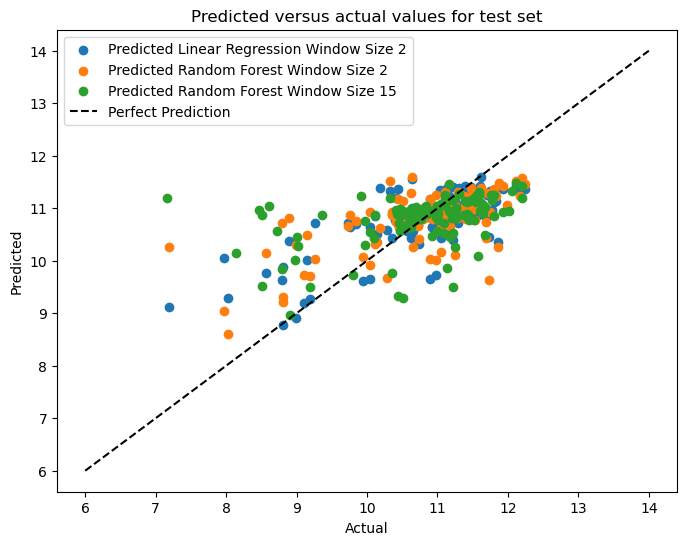

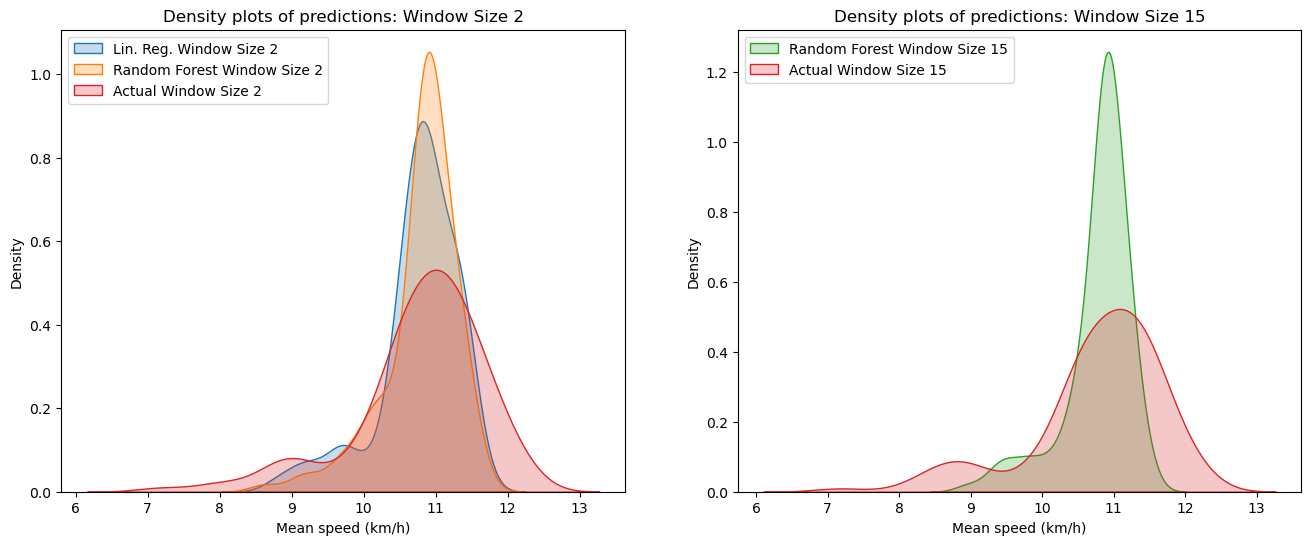

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_2, y_pred_lr2, label='Predicted Linear Regression Window Size 2')
plt.scatter(y_test_2, y_pred_rf2, label='Predicted Random Forest Window Size 2')
plt.scatter(y_test_15, y_pred_rf15, label='Predicted Random Forest Window Size 15')
plt.plot([6, 14], [6, 14], 'k--', label='Perfect Prediction')
plt.legend()
plt.title('Predicted versus actual values for test set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# plot density distributions of the residuals for the linear regression model and the random forest model
# make 2 plots, one for window size 2 and one for window size 15
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(y_pred_lr2, label='Lin. Reg. Window Size 2', fill=True, ax=ax[0], color='C0')
sns.kdeplot(y_pred_rf2, label='Random Forest Window Size 2', fill=True, ax=ax[0], color='C1')
sns.kdeplot(y_pred_rf15, label='Random Forest Window Size 15', fill=True, ax=ax[1], color='C2')

sns.kdeplot(y_test_2, label='Actual Window Size 2', fill=True, ax=ax[0], color='C3')
sns.kdeplot(y_test_15, label='Actual Window Size 15', fill=True, ax=ax[1], color='C3')



# set legend for ax 0, positioned top left
ax[0].legend(loc='upper left')
# set legend for ax 1
ax[1].legend(loc='upper left')

ax[0].set_title('Density plots of predictions: Window Size 2')
ax[0].set_xlabel('Mean speed (km/h)')
ax[0].set_ylabel('Density')

ax[1].set_title('Density plots of predictions: Window Size 15')
ax[1].set_xlabel('Mean speed (km/h)')
ax[1].set_ylabel('Density')
plt.show()



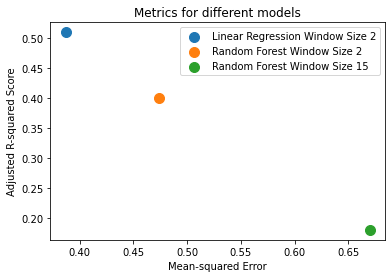

In [22]:
plt.scatter(0.38693838015478166, 0.5092219890584777, label='Linear Regression Window Size 2', c='C0', s=100)
plt.scatter(0.47363161735976095, 0.3992635649276851, label='Random Forest Window Size 2', c='C1', s=100)
plt.scatter(0.670143565934832, 0.18025261356921662, label='Random Forest Window Size 15', c='C2', s=100)
plt.xlabel('Mean-squared Error')
plt.ylabel('Adjusted R-squared Score')
plt.title('Metrics for different models')
plt.legend()
plt.show()

#### Result interpretation

Based on the test set evaluation, the backward stepwise linear regression trained on the window size of 2 (using the data from the previous day to predict the mean speed on the next day) performed the best, with an adjusted R-squared score of 0.50 (i.e., 50% of the variance in the model when adjusted for the number of features could be explained by the five selected features) and a mean squared error of 0.37. This adjusted R-squared score was actually the best so far, which is surprising and likely attributed to a lucky split of the data. This model performing the best is somewhat surprising because I believed that the backwards stepwise linear regression would prune out the variables that were highly correlated with each other, especially given that the threshold was 0.01, implying that the variables that would not be necessary for the model would be more likely to be removed. 

Meanwhile, given a pretty large discrepancy in the mean squared error between the test set and the training set (0.2), it is likely that the model was overfitted on the training set and did not perform as well on the testing set. For other models besides linear regression of window size 2, it seems like they underfit the data as well, performing poorly both on training and testing set metrics. Overall, it seemed the more complex the models were becoming, by including a greater window size or by using random forests instead of linear regression, the worse they were performing on the dataset.

To have perhaps more intuition as to where the errors might be coming from, one can look at the density plot of predictions for the different window sizes. You can see that the test distribution is a lot more spread out around the tails while the predicted values center a lot more closely around the mean. This is also evident from the scatter plot where the cluster of the data around the assumed mean is a lot closer to the line-of-best-fit while the values around the tails are more spread out and less accurate. This suggests that there may be underlying non-linear relationships or interactions in the data that are not captured by the linear regression model, likely stemming from the uncaptured variance in the data. It makes me think that the potential extension for this problem would be trying a non-linear function. To tie this to the previous point, even though the model may be missing some interactions among the data and a linear fit may not be ideal, it is still likely the model is may not be too complex.

### Executive Summary

In this project, I explored the relationship between my running data and my mean speed for the next day given a window of previous performance: past day, past week, or past two weeks. I used a dataset of approximately 600 days of running data, with each day having 5 features: distance, duration, step count, maximum speed, and calories burned. The two models I used were a backwards stepwise linear regression and a random forest regression. I used the adjusted R-squared score and the mean squared error as my metrics for the models. I found that backwards stepwise linear regression that only used data from one day before performed best compared to other models, with an adjusted-R-squared score of 0.50 and a mean-squared error of 0.37. This suggests that the model may be able to predict my mean speed for the next day based on the previous day's data with an error of 0.37 kmph, which is approximately 1/3 of my mean speed's standard deviation. I found that the most important predictor to determine my mean speed at the end of a period seemed to be my average weighted distance ran over that period. While the results are not entirely actionable, one thing I could look into is whether increasing the amount of distane I run would positively influence my mean speed. Intuitively, this could make sense as I would be improving my endurance and tolerating shorter distances a lot more easily. However, I am not entirely convinced since I could be running at a slower pace to balance out the longer distance.

On top of that, some limitations of this analysis include not accounting for the variance between the days in the selected window as well as using highly correlated variables. Future work could include using a non-linear model to account for the variance between the days in the selected window and using a different method to select the features for the model. Specifically, a proper time-series model could be used to examine seasonalities within data and include various predictors as exogenous variables. Including predictors such as hours of sleep, menstrual cycle stage, etc., could also be useful by helping to account for confounding factors and improve the model's performance.

### References

Beheshti, N. (2022, March 2). Random forest regression. Medium. https://towardsdatascience.com/random-forest-regression-5f605132d19d

Kwok, R. (2021, March 9). Stepwise regression tutorial in Python. Medium. https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922

Muralidhar, K. (2023, February 7). Demystifying R-squared and adjusted R-squared. Built In. https://builtin.com/data-science/adjusted-r-squared

Saini, A. (2022, August 26). Random forest algorithm for absolute beginners in data science. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/an-introduction-to-random-forest-algorithm-for-beginners/

Samsung Developers: Samsung Health API Reference. (n.d.). Samsung Developers. Retrieved February 21, 2023, from https://developer.samsung.com/health/android/data/api-reference/com/samsung/android/sdk/healthdata